In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols
from tqdm import tqdm

In [6]:
# Load data
folder = './data/science_jargon_sensationalism_csvs'
data = pd.DataFrame(columns=[ 'year', 'month', "title",'link_flair_text', 'domain','score', 'num_comments',  "sensationalism_score", "jargon_proportion", "url", "id"])
for file in tqdm(os.listdir(folder)):
    if not file.endswith('.csv'):
        print(f"Skipping {file}")
        continue
    year = file.split('_')[2]
    month = file.split('_')[3].split('.')[0]
    df = pd.read_csv(folder + "/" + file)
    
    # cleaning 
    df.dropna(inplace=True, subset=["link_flair_text", "title", "domain", "num_comments", "score", "id", "url"])
    df.drop_duplicates(subset='id', inplace=True)
    df = df[~df['link_flair_text'].str.endswith('AMA') & ~df['link_flair_text'].str.endswith('Discussion')]
    
    df = df[['jargon_proportion', 'score', 'num_comments', 'link_flair_text', "title", "sensationalism_score", "domain" , "url", "id"]]
    df["year"] = year
    df["month"] = month
    data = pd.concat([data, df])
# save to csv
data['num_comments'] = data['num_comments'].astype(int)
data["domain"] = data["domain"].astype(str)
data['link_flair_text'] = data['link_flair_text'].replace('computer sci', 'Computer Science')
data['link_flair_text'] = data['link_flair_text'].replace('Computer Sci', 'Computer Science')
#data.to_csv('./data/summed_for_regression_including_sensationalism_and_jargon.csv')

  0%|          | 0/85 [00:00<?, ?it/s]/var/folders/dr/xmdsvycs1g3dfskw1mj7syz00000gn/T/ipykernel_17608/265988083.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat([data, df])
 26%|██▌       | 22/85 [00:00<00:01, 51.80it/s]

Skipping .DS_Store


100%|██████████| 85/85 [00:02<00:00, 42.11it/s]


In [7]:
df

,jargon_proportion,score,num_comments,link_flair_text,title,sensationalism_score,domain,url,id,year,month
0,0.222222,1,0.0,Biology,Varroa mite resistance to miticide Amitraz Dr ...,0.412137,youtube.com,https://www.youtube.com/watch?v=F5zy3rU8dfY&am...,dbl4jx,2019,10
1,0.162791,43,16.0,Health,A comprehensive review of all e-cigarette/vapi...,0.528438,bmj.com,https://www.bmj.com/content/366/bmj.l5275.full,dblfac,2019,10
2,0.400000,0,0.0,Social Science,Study reveals vitae falsification issues in hi...,0.459159,eurekalert.org,https://www.eurekalert.org/pub_releases/2019-0...,dblxsu,2019,10
3,0.264706,1,11.0,Social Science,Legal purchasers of handguns with a prior DUI ...,0.532010,health.ucdavis.edu,https://health.ucdavis.edu/publish/news/newsro...,dbm95x,2019,10
4,0.107143,103,21.0,Psychology,People who live or think they live in a more e...,0.573095,psychologicalscience.org,https://www.psychologicalscience.org/news/rele...,dbm9s2,2019,10
...,...,...,...,...,...,...,...,...,...,...,...
4153,0.080000,45,1.0,Biology,"""Smoker's Face,"" a condition where smokers loo...",0.568060,eurekalert.org,https://www.eurekalert.org/pub_releases/2019-1...,dpu8y1,2019,10
4155,0.142857,6,11.0,Health,WANTED: Pictures of your poop for science,0.524337,seed.com,https://seed.com/poop/,dpucdt,2019,10
4156,0.142857,1,0.0,Environment,New flame retardants in electronics and childr...,0.541337,pubs.acs.org,https://pubs.acs.org/doi/abs/10.1021/acs.estle...,dpuxb6,2019,10
4157,0.250000,10,1.0,Biology,Memory editing from science fiction to clinica...,0.447850,nature.com,https://www.nature.com/articles/s41586-019-1433-7,dpvjbr,2019,10


In [10]:
domains_df = pd.read_csv("./data/domains_lm_and_manual_labeled.csv")
# for each domain label if it is within the 10 most posted for that domain category
for label in domains_df["label_voting_manual"].unique():
    top_domains = domains_df[domains_df["label_voting_manual"] == label].head(10)['domain'].tolist()
    data['is_top_domain_' + label] = data['domain'].apply(lambda x: x in top_domains)
    print(f"Most common labels in {label}:\n{top_domains}")

Most common labels in indecisive:
['meetingorganizer.copernicus.org', 'uptrennd.com', 'scienceswitch.com']
Most common labels in less_than_2:
['pjreddie.com', 'penisextenderr.com', 'piemultilingual.com', 'whystardie.blogspot.com', 'pico-max-grow-a-garden.kckb.st', 'technologyrates.mit.edu', 'piximus.net', 'pics.ee', 'pksubkuch.blogspot.com', 'techinformativa.blogspot.com']
Most common labels in news:
['eurekalert.org', 'psypost.org', 'theguardian.com', 'bbc.com', 'sciencealert.com', 'sciencenews.org', 'nytimes.com', 'newscientist.com', 'inverse.com', 'livescience.com']
Most common labels in repo:
['ncbi.nlm.nih.gov', 'doi.org', 'frontiersin.org', 'tandfonline.com', 'pubs.acs.org', 'nejm.org', 'arxiv.org', 'pubmed.ncbi.nlm.nih.gov', 'bmj.com', 'symbiosisonlinepublishing.com']
Most common labels in scam:
['mightyviral.com', 'moviesdost.com', 'hit2k.com', 'google.com', 'hiwebex.com', 'docs.google.com', 'vitasave.ca', 'blog.ebulkemailmarketing.com', 'chinavasion.com', 'a2zcrack.com']
Most 

In [11]:
data = data.merge(domains_df[['domain', 'label_voting_lm', 'label_voting_manual']], on='domain', how='left')

In [12]:
conditions = [
    data['link_flair_text'].isin(["Biology", "Medicine", "Health", "Neuroscience", "Cancer", "Epidemiology", "Genetics", "Animal Science"]),
    data['link_flair_text'].isin(["Chemistry", "Physics", "Earth Science", "Geology", "Astronomy", "Nanoscience"]),
    data['link_flair_text'].isin(["Psychology", "Social Science", "Anthropology", "Economics"]),
    data['link_flair_text'].isin(["Computer Science", "Engineering", "Materials Science", "Mathematics"]),
    data['link_flair_text'].isin(["Environment", "Paleontology"])
]

choices = ["Life Sciences", "Physical Sciences", "Social Sciences", "Engineering & Technology", "Environmental Sciences"]

# Apply np.select to assign categories
data['top_category'] = np.select(conditions, choices, default="Other")

In [14]:
data

,year,month,title,link_flair_text,domain,score,num_comments,sensationalism_score,jargon_proportion,url,...,is_top_domain_less_than_2,is_top_domain_news,is_top_domain_repo,is_top_domain_scam,is_top_domain_scientific,is_top_domain_social_media,is_top_domain_unknown,label_voting_lm,label_voting_manual,top_category
0,2018,03,The Bradford pear has created an ecological ni...,Biology,greenvilleonline.com,2,4,0.533427,0.181818,https://www.greenvilleonline.com/story/life/20...,...,False,False,False,False,False,False,False,less_than_2,less_than_2,Life Sciences
1,2018,03,Astronomers say they've discovered evidence of...,Astronomy,aftau.org,46,11,0.511129,0.068966,https://www.aftau.org/news-page-astronomy--ast...,...,False,False,False,False,False,False,False,scientific,scientific,Physical Sciences
2,2018,03,The first detection of 21 cm signal from hydro...,Astronomy,news.mit.edu,1,0,0.412405,0.083333,http://news.mit.edu/2018/astronomers-detect-ea...,...,False,False,False,False,False,False,False,news,news,Physical Sciences
3,2018,03,Universe's First Stars Detected? Get the Facts.,Astronomy,news.nationalgeographic.com,1,1,0.561694,0.000000,https://news.nationalgeographic.com/2018/02/fi...,...,False,False,False,False,False,False,False,news,news,Physical Sciences
4,2018,03,Simple telescope picks up hint of the Universe...,Astronomy,arstechnica.com,3,2,0.492255,0.333333,https://arstechnica.com/science/2018/02/signal...,...,False,False,False,False,False,False,False,news,news,Physical Sciences
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197782,2019,10,"""Smoker's Face,"" a condition where smokers loo...",Biology,eurekalert.org,45,1,0.568060,0.080000,https://www.eurekalert.org/pub_releases/2019-1...,...,False,True,False,False,False,False,False,news,news,Life Sciences
197783,2019,10,WANTED: Pictures of your poop for science,Health,seed.com,6,11,0.524337,0.142857,https://seed.com/poop/,...,False,False,False,False,False,False,False,less_than_2,less_than_2,Life Sciences
197784,2019,10,New flame retardants in electronics and childr...,Environment,pubs.acs.org,1,0,0.541337,0.142857,https://pubs.acs.org/doi/abs/10.1021/acs.estle...,...,False,False,True,False,False,False,False,repo,repo,Environmental Sciences
197785,2019,10,Memory editing from science fiction to clinica...,Biology,nature.com,10,1,0.447850,0.250000,https://www.nature.com/articles/s41586-019-1433-7,...,False,False,False,False,True,False,False,scientific,scientific,Life Sciences


In [15]:
data.to_csv('./data/combined_for_analysis_sensationalism_jargon_categories_domain_labels.csv')

# From here on analysis only
To be ignored if just recreating the data csv

In [6]:
data.corr()

ValueError: could not convert string to float: 'The Bradford pear has created an ecological nightmare in South Carolina'

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102],
 [Text(0, 0, 'Biology'),
  Text(1, 0, 'Astronomy'),
  Text(2, 0, 'Environment'),
  Text(3, 0, 'Physics'),
  Text(4, 0, 'Anthropology'),
  Text(5, 0, 'Health'),
  Text(6, 0, 'Cancer'),
  Text(7, 0, 'Psychology'),
  Text(8, 0, 'Engineering'),
  Text(9, 0, 'Medicine'),
  Text(10, 0, 'Computer Science'),
  Text(11, 0, 'Social Science'),
  Text(12, 0, 'Neuroscience'),
  Text(13, 0, 'Animal 

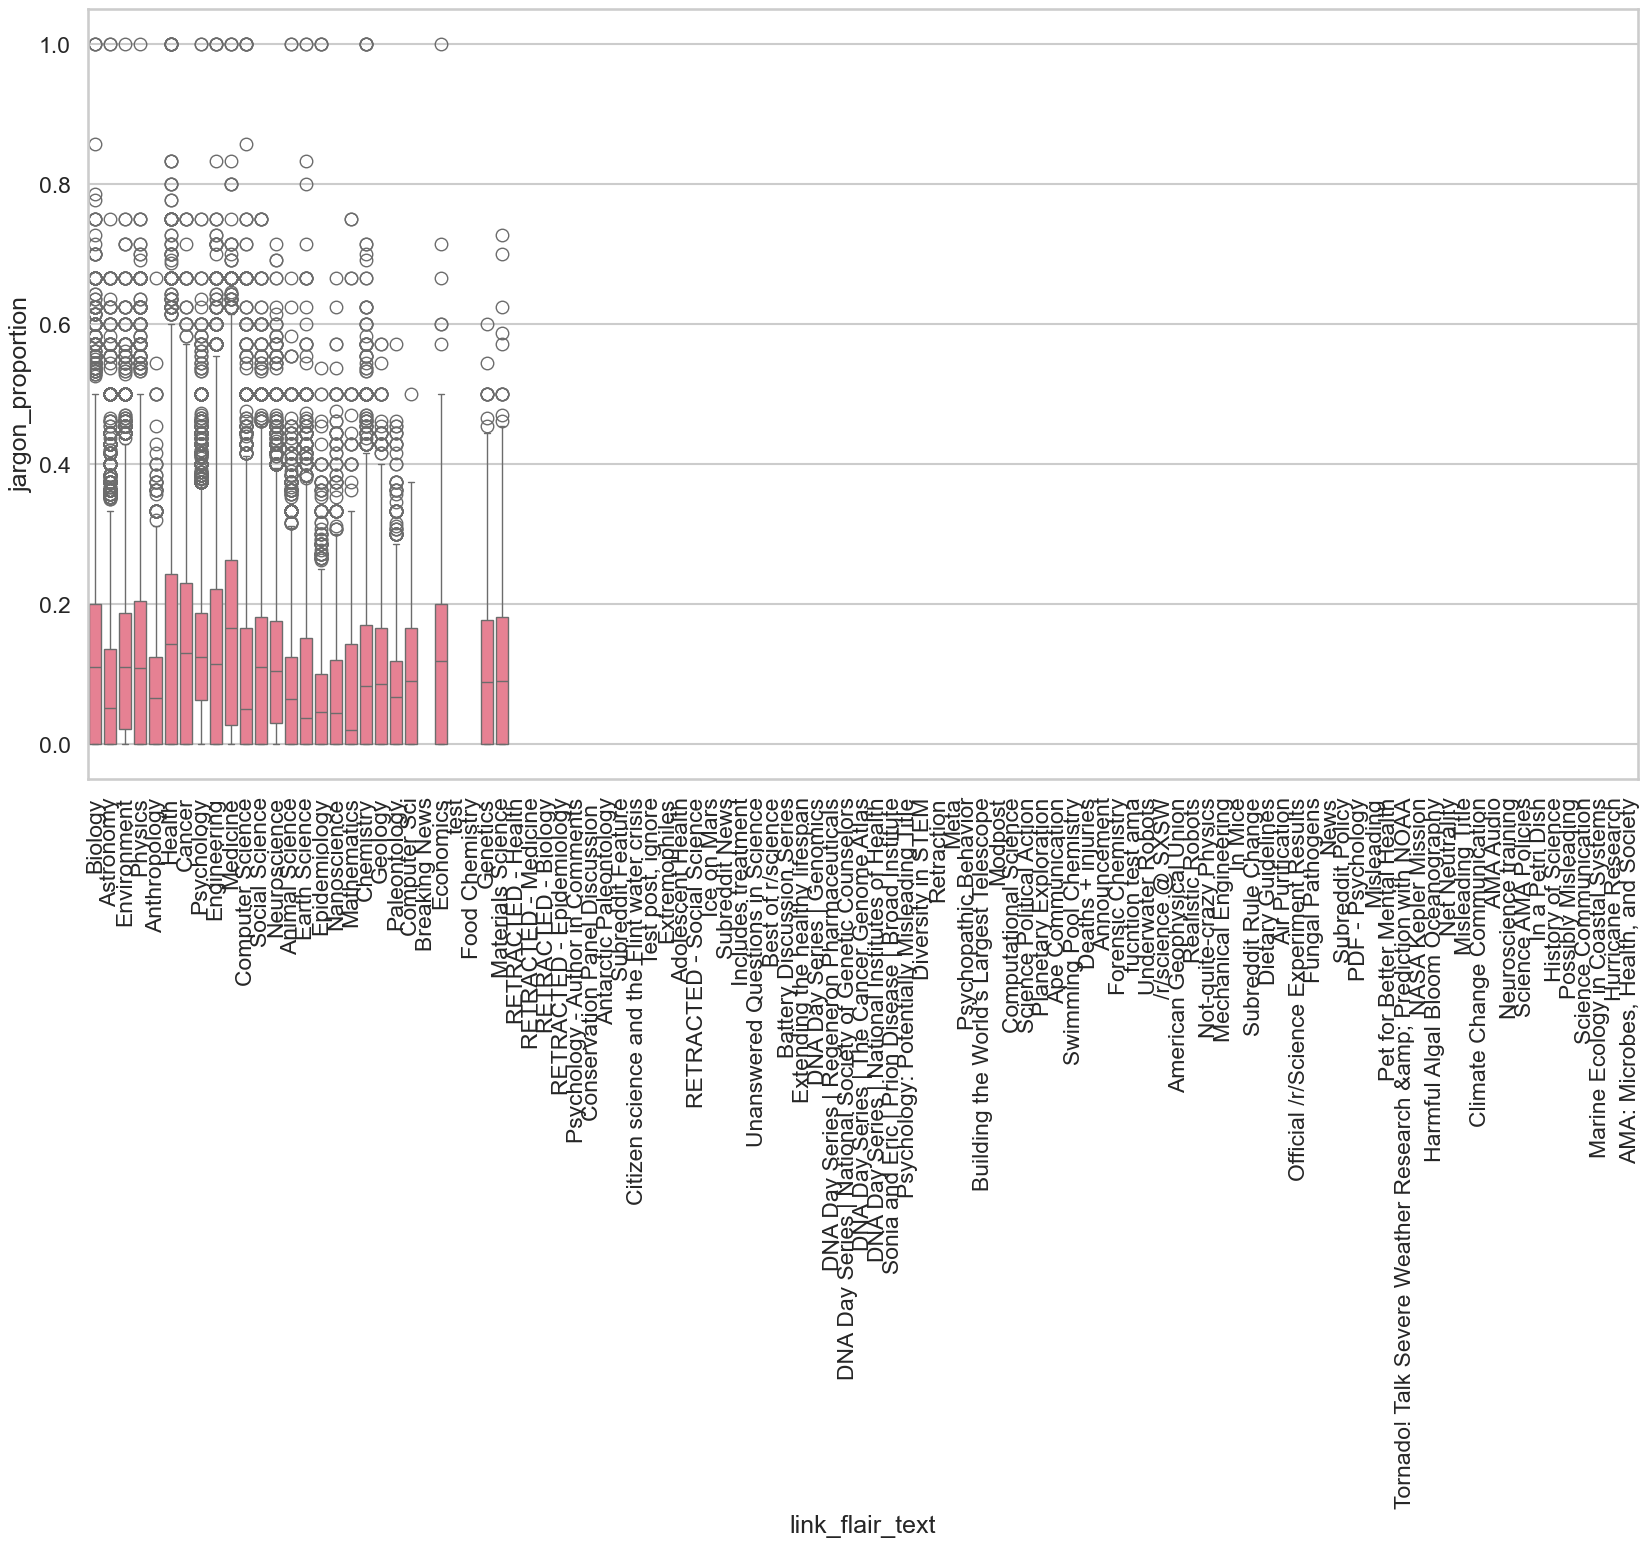

In [6]:
# seaborn plot of jargon measures over the categories
sns.set(style="whitegrid")
sns.set_palette("husl")
sns.set_context("talk")
plt.figure(figsize=(20, 10))
sns.boxplot(x="link_flair_text", y="jargon_proportion", data=data)
plt.xticks(rotation=90)

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'Social Sciences'),
  Text(1, 0, 'Physical Sciences'),
  Text(2, 0, 'Life Sciences'),
  Text(3, 0, 'Environmental Sciences'),
  Text(4, 0, 'Engineering & Technology'),
  Text(5, 0, 'Other')])

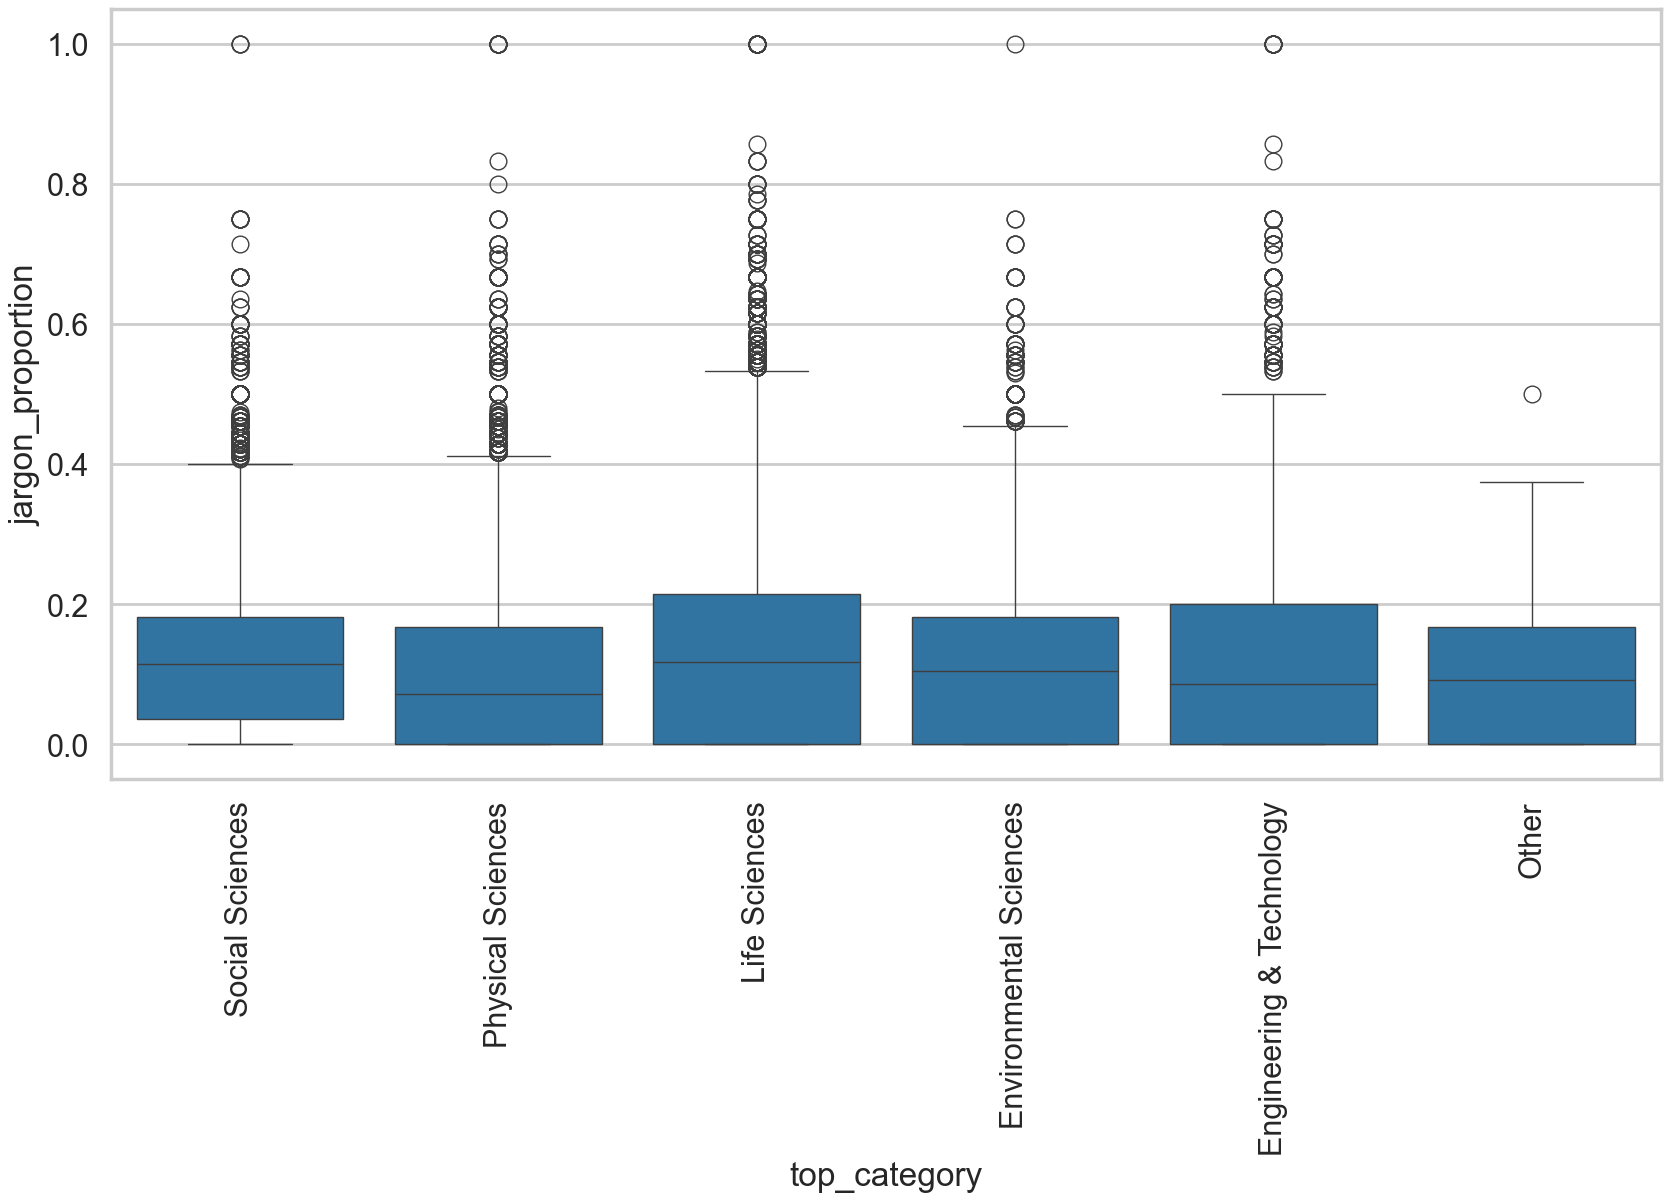

In [19]:
# seaborn plot of jargon measures over the categories
sns.set(style="whitegrid")
sns.set_palette("tab10")
sns.set_context("poster")
plt.figure(figsize=(20, 10))
sns.boxplot(x="top_category", y="jargon_proportion", data=data)
plt.xticks(rotation=90)

In [24]:
data[data["domain"] =='nature.com']["url"]

29        https://www.nature.com/articles/d41586-018-025...
40              https://www.nature.com/articles/nature25791
101       https://www.nature.com/articles/d41586-018-023...
185       https://www.nature.com/articles/s41567-018-0048-5
207       https://www.nature.com/articles/d41586-018-026...
                                ...                        
197710    https://www.nature.com/articles/s41374-019-0335-5
197723    https://www.nature.com/articles/d41586-019-032...
197754    https://www.nature.com/articles/s41467-019-130...
197774    https://www.nature.com/articles/s41377-019-0201-7
197785    https://www.nature.com/articles/s41586-019-1433-7
Name: url, Length: 9789, dtype: object

In [13]:
df[df["domain"] == "frontiersin.org"]["url"]


2839    https://www.frontiersin.org/articles/10.3389/f...
2940    https://www.frontiersin.org/articles/10.3389/f...
Name: url, dtype: object

In [13]:
data

,year,month,title,link_flair_text,domain,score,num_comments,sensationalism_score,jargon_proportion,url,...,is_top_domain_less_than_2,is_top_domain_news,is_top_domain_repo,is_top_domain_scam,is_top_domain_scientific,is_top_domain_social_media,is_top_domain_unknown,label_voting_lm,label_voting_manual,top_category
0,2018,03,The Bradford pear has created an ecological ni...,Biology,greenvilleonline.com,2,4,0.533427,0.181818,https://www.greenvilleonline.com/story/life/20...,...,False,False,False,False,False,False,False,less_than_2,less_than_2,Life Sciences
1,2018,03,Astronomers say they've discovered evidence of...,Astronomy,aftau.org,46,11,0.511129,0.068966,https://www.aftau.org/news-page-astronomy--ast...,...,False,False,False,False,False,False,False,scientific,scientific,Physical Sciences
2,2018,03,The first detection of 21 cm signal from hydro...,Astronomy,news.mit.edu,1,0,0.412405,0.083333,http://news.mit.edu/2018/astronomers-detect-ea...,...,False,False,False,False,False,False,False,news,news,Physical Sciences
3,2018,03,Universe's First Stars Detected? Get the Facts.,Astronomy,news.nationalgeographic.com,1,1,0.561694,0.000000,https://news.nationalgeographic.com/2018/02/fi...,...,False,False,False,False,False,False,False,news,news,Physical Sciences
4,2018,03,Simple telescope picks up hint of the Universe...,Astronomy,arstechnica.com,3,2,0.492255,0.333333,https://arstechnica.com/science/2018/02/signal...,...,False,False,False,False,False,False,False,news,news,Physical Sciences
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197782,2019,10,"""Smoker's Face,"" a condition where smokers loo...",Biology,eurekalert.org,45,1,0.568060,0.080000,https://www.eurekalert.org/pub_releases/2019-1...,...,False,True,False,False,False,False,False,news,news,Life Sciences
197783,2019,10,WANTED: Pictures of your poop for science,Health,seed.com,6,11,0.524337,0.142857,https://seed.com/poop/,...,False,False,False,False,False,False,False,less_than_2,less_than_2,Life Sciences
197784,2019,10,New flame retardants in electronics and childr...,Environment,pubs.acs.org,1,0,0.541337,0.142857,https://pubs.acs.org/doi/abs/10.1021/acs.estle...,...,False,False,True,False,False,False,False,repo,repo,Environmental Sciences
197785,2019,10,Memory editing from science fiction to clinica...,Biology,nature.com,10,1,0.447850,0.250000,https://www.nature.com/articles/s41586-019-1433-7,...,False,False,False,False,True,False,False,scientific,scientific,Life Sciences
